In [103]:
import os
from pathlib import Path

from itertools import chain, product

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import time
from datetime import datetime, timedelta
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [ ]:
# config settings

# date of forecast generation
forecast_date = datetime.today().date()
#forecast_date = datetime(2024, 12, 26).date()
print(forecast_date)
 #"2024-10-13", "2024-11-24", "2024-12-22"

# next Saturday: weekly forecasts are relative to this date
ref_date = forecast_date - timedelta((forecast_date.weekday() + 2) % 7 - 7)
print(f'reference date = {ref_date}')

# maximum forecast horizon
max_horizon = 5

# bagging setup
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.025, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.975]
q_labels = ['0.025', '0.05', '0.1', '0.25', '0.5', '0.75',  '0.9', '0.95', '0.975']


2024-12-26
reference date = 2024-12-28


In [105]:
os.chdir('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting')

In [106]:
import sys
sys.path.append('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting/GBM/code')
import loader 


In [107]:
dat = pd.read_csv('/Users/dk29776/Dropbox/UTAustin/flu-metrocast/target-data/oracle-output.csv')
dat.target_end_date.max()
dat

,Unnamed: 0,target_end_date,location,target,oracle_value,population
0,1,2016-01-02,Bronx,ILI ED visits,165,1472654
1,2,2016-01-02,Brooklyn,ILI ED visits,166,2736074
2,3,2016-01-02,Manhattan,ILI ED visits,84,1694251
3,4,2016-01-02,NYC,ILI ED visits,744,8804190
4,5,2016-01-02,Queens,ILI ED visits,280,2405464
...,...,...,...,...,...,...
2815,2816,2024-12-28,Brooklyn,ILI ED visits,578,2736074
2816,2817,2024-12-28,Manhattan,ILI ED visits,305,1694251
2817,2818,2024-12-28,NYC,ILI ED visits,2042,8804190
2818,2819,2024-12-28,Queens,ILI ED visits,511,2405464


In [108]:
dat['inc'] = dat['oracle_value']/(dat['population']/ 100000)
dat['target_end_date'] = pd.to_datetime(dat['target_end_date'])
dat.rename(columns={'population': 'pop'}, inplace=True)
dat.rename(columns={'target_end_date': 'wk_end_date'}, inplace=True)
dat = dat[['wk_end_date', 'location', 'inc', 'pop']]
dat = dat[dat['wk_end_date'] < pd.Timestamp(ref_date)]
dat

,wk_end_date,location,inc,pop
0,2016-01-02,Bronx,11.204261,1472654
1,2016-01-02,Brooklyn,6.067087,2736074
2,2016-01-02,Manhattan,4.957943,1694251
3,2016-01-02,NYC,8.450522,8804190
4,2016-01-02,Queens,11.640166,2405464
...,...,...,...,...
2809,2024-12-21,Brooklyn,74.449741,2736074
2810,2024-12-21,Manhattan,56.839276,1694251
2811,2024-12-21,NYC,76.520384,8804190
2812,2024-12-21,Queens,70.797152,2405464


In [109]:
dat['wk_end_date'].max()

Timestamp('2024-12-21 00:00:00')

In [110]:
# Create epiweek and year columns
dat_arrange = dat.assign(
    epiweek=dat['wk_end_date'].dt.isocalendar().week,
    year=dat['wk_end_date'].dt.year
)


dat_arrange = dat_arrange.assign(
    season=lambda x: x['year'].astype(str) + "/" + (x['year'] + 1).astype(str).str[-2:])
dat_arrange['season_week'] = loader.convert_epiweek_to_season_week(dat_arrange['year'].to_numpy(), dat_arrange['epiweek'].to_numpy())
df = dat_arrange
df


,wk_end_date,location,inc,pop,epiweek,year,season,season_week
0,2016-01-02,Bronx,11.204261,1472654,53,2016,2016/17,23
1,2016-01-02,Brooklyn,6.067087,2736074,53,2016,2016/17,23
2,2016-01-02,Manhattan,4.957943,1694251,53,2016,2016/17,23
3,2016-01-02,NYC,8.450522,8804190,53,2016,2016/17,23
4,2016-01-02,Queens,11.640166,2405464,53,2016,2016/17,23
...,...,...,...,...,...,...,...,...
2809,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21
2810,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21
2811,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21
2812,2024-12-21,Queens,70.797152,2405464,51,2024,2024/25,21


In [111]:
df.wk_end_date.max()

Timestamp('2024-12-21 00:00:00')

In [112]:
df['log_pop'] = np.log(df['pop'])
df['inc_4rt'] = (df['inc'] + 0.01)**0.25
df['inc_4rt_scale_factor'] = df \
.assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt'])) \
.groupby(['location'])['inc_4rt_in_season'] \
.transform(lambda x: x.quantile(0.95))

df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
df['inc_4rt_center_factor'] = df \
.assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt_cs'])) \
.groupby(['location'])['inc_4rt_cs_in_season'] \
.transform(lambda x: x.mean())
df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
df
  

,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,2016-01-02,Bronx,11.204261,1472654,53,2016,2016/17,23,14.202577,1.829965,3.190612,-0.182826,0.754581
1,2016-01-02,Brooklyn,6.067087,2736074,53,2016,2016/17,23,14.822035,1.570088,2.769335,-0.193446,0.758361
2,2016-01-02,Manhattan,4.957943,1694251,53,2016,2016/17,23,14.342751,1.492946,2.678587,-0.199532,0.754823
3,2016-01-02,NYC,8.450522,8804190,53,2016,2016/17,23,15.990738,1.705490,2.894728,-0.169620,0.756763
4,2016-01-02,Queens,11.640166,2405464,53,2016,2016/17,23,14.693253,1.847494,2.910554,-0.129502,0.762085
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21,14.822035,2.937517,2.769335,0.298552,0.758361
2810,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21,14.342751,2.745878,2.678587,0.266486,0.754823
2811,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21,15.990738,2.957730,2.894728,0.261484,0.756763
2812,2024-12-21,Queens,70.797152,2405464,51,2024,2024/25,21,14.693253,2.900810,2.910554,0.231154,0.762085


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_99941/3611234292.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=nhsn_to_plot,


<Axes: xlabel='season_week', ylabel='inc_4rt_cs'>

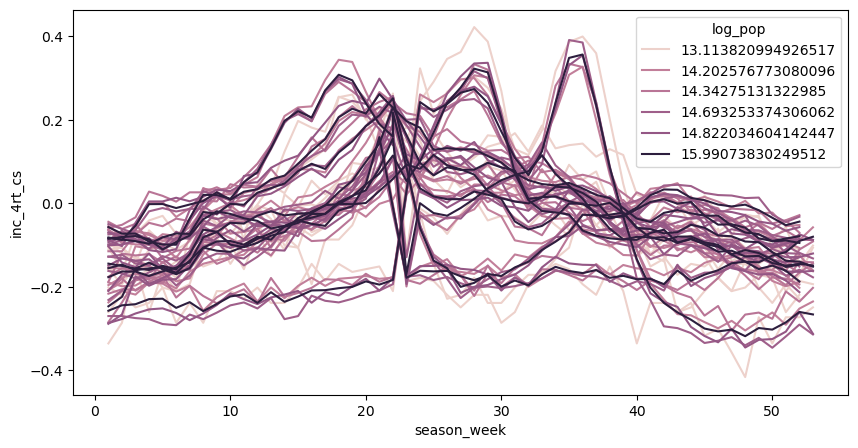

In [113]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

nhsn_to_plot = df.assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=nhsn_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax)

In [114]:
# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['location']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

# season week relative to christmas
df = df.merge(
    loader.get_holidays() \
      .query("holiday == 'Christmas Day'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']

In [115]:
df

,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,inc_4rt_cs,inc_4rt_center_factor,location_Bronx,location_Brooklyn,location_Manhattan,location_NYC,location_Queens,location_Staten Island,xmas_week,delta_xmas
0,2016-01-02,Bronx,11.204261,1472654,53,2016,2016/17,23,14.202577,1.829965,...,-0.182826,0.754581,1,0,0,0,0,0,22.0,1.0
1,2016-01-02,Brooklyn,6.067087,2736074,53,2016,2016/17,23,14.822035,1.570088,...,-0.193446,0.758361,0,1,0,0,0,0,22.0,1.0
2,2016-01-02,Manhattan,4.957943,1694251,53,2016,2016/17,23,14.342751,1.492946,...,-0.199532,0.754823,0,0,1,0,0,0,22.0,1.0
3,2016-01-02,NYC,8.450522,8804190,53,2016,2016/17,23,15.990738,1.705490,...,-0.169620,0.756763,0,0,0,1,0,0,22.0,1.0
4,2016-01-02,Queens,11.640166,2405464,53,2016,2016/17,23,14.693253,1.847494,...,-0.129502,0.762085,0,0,0,0,1,0,22.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21,14.822035,2.937517,...,0.298552,0.758361,0,1,0,0,0,0,NaN,NaN
2810,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21,14.342751,2.745878,...,0.266486,0.754823,0,0,1,0,0,0,NaN,NaN
2811,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21,15.990738,2.957730,...,0.261484,0.756763,0,0,0,1,0,0,NaN,NaN
2812,2024-12-21,Queens,70.797152,2405464,51,2024,2024/25,21,14.693253,2.900810,...,0.231154,0.762085,0,0,0,0,1,0,NaN,NaN


In [116]:
feat_names

['inc_4rt_cs',
 'season_week',
 'log_pop',
 'location_Bronx',
 'location_Brooklyn',
 'location_Manhattan',
 'location_NYC',
 'location_Queens',
 'location_Staten Island',
 'delta_xmas']

In [117]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['location'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

     wk_end_date       location        inc      pop  epiweek  year   season  \
0     2016-01-02          Bronx  11.204261  1472654       53  2016  2016/17   
1     2016-01-02       Brooklyn   6.067087  2736074       53  2016  2016/17   
2     2016-01-02      Manhattan   4.957943  1694251       53  2016  2016/17   
3     2016-01-02            NYC   8.450522  8804190       53  2016  2016/17   
4     2016-01-02         Queens  11.640166  2405464       53  2016  2016/17   
...          ...            ...        ...      ...      ...   ...      ...   
2809  2024-12-21       Brooklyn  74.449741  2736074       51  2024  2024/25   
2810  2024-12-21      Manhattan  56.839276  1694251       51  2024  2024/25   
2811  2024-12-21            NYC  76.520384  8804190       51  2024  2024/25   
2812  2024-12-21         Queens  70.797152  2405464       51  2024  2024/25   
2813  2024-12-21  Staten Island  34.493401   495747       51  2024  2024/25   

     season_week    log_pop   inc_4rt  ...  \
0    

/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(taylor_coefs_one_column_grp,
/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this w

In [118]:
df.shape

(2814, 59)

In [119]:
new_feat_names

['inc_4rt_cs_lag1',
 'inc_4rt_cs_lag2',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2',
 'inc_4rt_cs_rollmean_w2_lag1',
 'inc_4rt_cs_rollmean_w2_lag2',
 'inc_4rt_cs_rollmean_w4_lag1',
 'in

In [120]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
     wk_end_date       location        inc      pop  epiweek  year   season  \
0     2016-01-02          Bronx  11.204261  1472654       53  2016  2016/17   
1     2016-01-02       Brooklyn   6.067087  2736074       53  2016  2016/17   
2     2016-01-02      Manhattan   4.957943  1694251       53  2016  2016/17   
3     2016-01-02            NYC   8.450522  8804190       53  2016  2016/17   
4     2016-01-02         Queens  11.640166  2405464       53  2016  2016/17   
...          ...            ...        ...      ...      ...   ...      ...   
2809  2024-12-21       Brooklyn  74.449741  2736074       51  2024  2024/25   
2810  2024-12-21      Manhattan  56.839276  1694251       51  2024  2024/25   
2811  2024-12-21            NYC  76.520384  8804190       51  2024  2024/25   
2812  2024-12-21         Queens  70.797152  2405464       51  2024  2024/25   
2813  2024-12-21  Staten Island  34.493401   495747       51  2024  2024/25   

     season_week    log_pop   inc_4rt  

In [121]:
df_with_pred_targets.shape

(14070, 62)

In [122]:
df_with_pred_targets.wk_end_date.max()

Timestamp('2024-12-21 00:00:00')

In [123]:
df_with_pred_targets[df_with_pred_targets['inc_4rt_cs_target'].isna()]


,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
2808,2024-12-21,Bronx,112.925371,1472654,51,2024,2024/25,21,14.202577,3.259924,...,0.219685,0.027526,0.033246,-0.048983,-0.057491,-0.041958,-0.109444,NaN,1,NaN
2809,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21,14.822035,2.937517,...,0.256394,0.021973,0.034190,-0.045151,-0.035798,-0.038059,-0.077497,NaN,1,NaN
2810,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21,14.342751,2.745878,...,0.238831,0.021838,0.039279,-0.022222,-0.051971,-0.035603,-0.054731,NaN,1,NaN
2811,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21,15.990738,2.957730,...,0.230154,0.025098,0.034441,0.020224,-0.065289,-0.012464,-0.050543,NaN,1,NaN
2812,2024-12-21,Queens,70.797152,2405464,51,2024,2024/25,21,14.693253,2.900810,...,0.209884,0.027486,0.032208,0.033884,-0.034932,0.005831,-0.043451,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21,14.822035,2.937517,...,0.256394,0.021973,0.034190,-0.045151,-0.035798,-0.038059,-0.077497,NaN,5,NaN
2810,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21,14.342751,2.745878,...,0.238831,0.021838,0.039279,-0.022222,-0.051971,-0.035603,-0.054731,NaN,5,NaN
2811,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21,15.990738,2.957730,...,0.230154,0.025098,0.034441,0.020224,-0.065289,-0.012464,-0.050543,NaN,5,NaN
2812,2024-12-21,Queens,70.797152,2405464,51,2024,2024/25,21,14.693253,2.900810,...,0.209884,0.027486,0.032208,0.033884,-0.034932,0.005831,-0.043451,NaN,5,NaN


In [124]:
df_with_pred_targets2 = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")

In [125]:
df_with_pred_targets2.shape

(10980, 62)

In [126]:
#date_list <- c("2023-10-01", "2023-11-05", "2023-12-10", "2024-01-14", "2024-02-18", "2024-03-24")

In [127]:
df_with_pred_targets = df_with_pred_targets2
    

# "test set" df used to generate look-ahead predictions
df_test = df_with_pred_targets \
    .loc[df_with_pred_targets.wk_end_date == df_with_pred_targets.wk_end_date.max()] \
    .copy()

x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [128]:
df_test

,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
2808,2024-12-21,Bronx,112.925371,1472654,51,2024,2024/25,21,14.202577,3.259924,...,0.219685,0.027526,0.033246,-0.048983,-0.057491,-0.041958,-0.109444,NaN,1,NaN
2809,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21,14.822035,2.937517,...,0.256394,0.021973,0.034190,-0.045151,-0.035798,-0.038059,-0.077497,NaN,1,NaN
2810,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21,14.342751,2.745878,...,0.238831,0.021838,0.039279,-0.022222,-0.051971,-0.035603,-0.054731,NaN,1,NaN
2811,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21,15.990738,2.957730,...,0.230154,0.025098,0.034441,0.020224,-0.065289,-0.012464,-0.050543,NaN,1,NaN
2812,2024-12-21,Queens,70.797152,2405464,51,2024,2024/25,21,14.693253,2.900810,...,0.209884,0.027486,0.032208,0.033884,-0.034932,0.005831,-0.043451,NaN,1,NaN
2813,2024-12-21,Staten Island,34.493401,495747,51,2024,2024/25,21,13.113821,2.423625,...,0.267130,0.032102,0.050336,0.053660,-0.030967,0.036942,-0.048128,NaN,1,NaN
2808,2024-12-21,Bronx,112.925371,1472654,51,2024,2024/25,21,14.202577,3.259924,...,0.219685,0.027526,0.033246,-0.048983,-0.057491,-0.041958,-0.109444,NaN,2,NaN
2809,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21,14.822035,2.937517,...,0.256394,0.021973,0.034190,-0.045151,-0.035798,-0.038059,-0.077497,NaN,2,NaN
2810,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21,14.342751,2.745878,...,0.238831,0.021838,0.039279,-0.022222,-0.051971,-0.035603,-0.054731,NaN,2,NaN
2811,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21,15.990738,2.957730,...,0.230154,0.025098,0.034441,0.020224,-0.065289,-0.012464,-0.050543,NaN,2,NaN


In [129]:



# seed for random number generation, based on reference date
rng_seed = int(time.mktime(ref_date.timetuple()))
rng = np.random.default_rng(seed=rng_seed)
# seeds for lgb model fits, one per combination of bag and quantile level
lgb_seeds = rng.integers(1e8, size=(num_bags, len(q_levels)))

# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

train_seasons = df_train['season'].unique()

# Convert season_week and delta_xmas to numeric
x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')

x_test['season_week'] = pd.to_numeric(x_test['season_week'], errors='coerce')
x_test['delta_xmas'] = pd.to_numeric(x_test['delta_xmas'], errors='coerce')

#print(x_train.dtypes[x_train.dtypes == 'object'])
#print(x_test.dtypes[x_test.dtypes == 'object'])

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_seasons = rng.choice(
        train_seasons,
        size = int(len(train_seasons) * bag_frac_samples),
        replace=False)
    bag_obs_inds = df_train['season'].isin(bag_seasons)
    
    for q_ind, q_level in enumerate(q_levels):
        # fit to bag
        model = lgb.LGBMRegressor(verbosity=-1,
                                    # hist_pool_size=1000,
                                    # objective='mean_absolute_error')
                                    objective='quantile',
                                    alpha = q_level,
                                    random_state=lgb_seeds[b, q_ind])
        model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
        
        # oob predictions and test set predictions
        #oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
        test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)

# df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
# df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_99941/1290929818.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_99941/1290929818.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_99941/1290929818.py:21: SettingWithCo

bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
b

In [130]:
#oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
test_pred_qs = np.median(test_preds_by_bag, axis=1)
test_pred_qs_sorted = np.sort(test_pred_qs, axis=1)  # Sort to enforce monotonicity
test_pred_qs_sorted.shape

test_pred_qs_df = pd.DataFrame(test_pred_qs_sorted)
test_pred_qs_df.columns = q_labels
test_pred_qs_df

,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,-0.097823,-0.067902,-0.047755,-0.031899,-0.013272,0.008396,0.029735,0.032170,0.054808
1,-0.117807,-0.078902,-0.057698,-0.042943,-0.015082,-0.001013,0.016538,0.026855,0.052695
2,-0.108520,-0.081383,-0.057262,-0.040575,-0.017526,-0.001443,0.024037,0.028925,0.054622
3,-0.099599,-0.072929,-0.050872,-0.033876,-0.021323,0.000468,0.027810,0.033074,0.057279
4,-0.071275,-0.051880,-0.046507,-0.027853,-0.019723,0.005030,0.027348,0.035487,0.052439
5,-0.122462,-0.093459,-0.069099,-0.040859,-0.019243,0.009470,0.034967,0.037940,0.066376
6,-0.104881,-0.083503,-0.059544,-0.044033,-0.034173,-0.014315,0.023099,0.037403,0.066556
7,-0.125805,-0.098093,-0.070408,-0.066103,-0.041382,-0.031597,0.004408,0.027221,0.064524
8,-0.116247,-0.095654,-0.070659,-0.052313,-0.034147,-0.021319,0.019330,0.032611,0.065976
9,-0.109708,-0.086625,-0.063532,-0.046645,-0.036435,-0.019091,0.022550,0.035803,0.070637


In [131]:
df_test.reset_index(drop=True, inplace=True)
df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)
df_test_w_preds

,wk_end_date,location,inc,pop,epiweek,year,season,season_week,log_pop,inc_4rt,...,delta_target,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,2024-12-21,Bronx,112.925371,1472654,51,2024,2024/25,21,14.202577,3.259924,...,NaN,-0.097823,-0.067902,-0.047755,-0.031899,-0.013272,0.008396,0.029735,0.032170,0.054808
1,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21,14.822035,2.937517,...,NaN,-0.117807,-0.078902,-0.057698,-0.042943,-0.015082,-0.001013,0.016538,0.026855,0.052695
2,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21,14.342751,2.745878,...,NaN,-0.108520,-0.081383,-0.057262,-0.040575,-0.017526,-0.001443,0.024037,0.028925,0.054622
3,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21,15.990738,2.957730,...,NaN,-0.099599,-0.072929,-0.050872,-0.033876,-0.021323,0.000468,0.027810,0.033074,0.057279
4,2024-12-21,Queens,70.797152,2405464,51,2024,2024/25,21,14.693253,2.900810,...,NaN,-0.071275,-0.051880,-0.046507,-0.027853,-0.019723,0.005030,0.027348,0.035487,0.052439
5,2024-12-21,Staten Island,34.493401,495747,51,2024,2024/25,21,13.113821,2.423625,...,NaN,-0.122462,-0.093459,-0.069099,-0.040859,-0.019243,0.009470,0.034967,0.037940,0.066376
6,2024-12-21,Bronx,112.925371,1472654,51,2024,2024/25,21,14.202577,3.259924,...,NaN,-0.104881,-0.083503,-0.059544,-0.044033,-0.034173,-0.014315,0.023099,0.037403,0.066556
7,2024-12-21,Brooklyn,74.449741,2736074,51,2024,2024/25,21,14.822035,2.937517,...,NaN,-0.125805,-0.098093,-0.070408,-0.066103,-0.041382,-0.031597,0.004408,0.027221,0.064524
8,2024-12-21,Manhattan,56.839276,1694251,51,2024,2024/25,21,14.342751,2.745878,...,NaN,-0.116247,-0.095654,-0.070659,-0.052313,-0.034147,-0.021319,0.019330,0.032611,0.065976
9,2024-12-21,NYC,76.520384,8804190,51,2024,2024/25,21,15.990738,2.957730,...,NaN,-0.109708,-0.086625,-0.063532,-0.046645,-0.036435,-0.019091,0.022550,0.035803,0.070637


In [132]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['wk_end_date' ,'location', 'pop',
                'inc_4rt_cs', 'horizon',
                'inc_4rt_center_factor', 'inc_4rt_scale_factor']
preds_df = df_test_w_preds[cols_to_keep + q_labels]
preds_df = pd.melt(preds_df,
                id_vars=cols_to_keep,
                var_name='quantile',
                value_name = 'delta_hat')
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat
0,2024-12-21,Bronx,1472654,0.263951,1,0.754581,3.190612,0.025,-0.097823
1,2024-12-21,Brooklyn,2736074,0.298552,1,0.758361,2.769335,0.025,-0.117807
2,2024-12-21,Manhattan,1694251,0.266486,1,0.754823,2.678587,0.025,-0.108520
3,2024-12-21,NYC,8804190,0.261484,1,0.756763,2.894728,0.025,-0.099599
4,2024-12-21,Queens,2405464,0.231154,1,0.762085,2.910554,0.025,-0.071275
...,...,...,...,...,...,...,...,...,...
265,2024-12-21,Brooklyn,2736074,0.298552,5,0.758361,2.769335,0.975,0.089522
266,2024-12-21,Manhattan,1694251,0.266486,5,0.754823,2.678587,0.975,0.088493
267,2024-12-21,NYC,8804190,0.261484,5,0.756763,2.894728,0.975,0.091059
268,2024-12-21,Queens,2405464,0.231154,5,0.762085,2.910554,0.975,0.094253


In [133]:
# build data frame with predictions on the original scale
preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
preds_df['value'] = np.maximum(preds_df['value'], 0.0)
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat,inc_4rt_cs_target_hat,inc_4rt_target_hat,value
0,2024-12-21,Bronx,1472654,0.263951,1,0.754581,3.190612,0.025,-0.097823,0.166127,2.946830,1105.699126
1,2024-12-21,Brooklyn,2736074,0.298552,1,0.758361,2.769335,0.025,-0.117807,0.180745,2.610091,1260.913275
2,2024-12-21,Manhattan,1694251,0.266486,1,0.754823,2.678587,0.025,-0.108520,0.157966,2.454112,609.017469
3,2024-12-21,NYC,8804190,0.261484,1,0.756763,2.894728,0.025,-0.099599,0.161885,2.668422,4435.091796
4,2024-12-21,Queens,2405464,0.231154,1,0.762085,2.910554,0.025,-0.071275,0.159880,2.692649,1256.644795
...,...,...,...,...,...,...,...,...,...,...,...,...
265,2024-12-21,Brooklyn,2736074,0.298552,5,0.758361,2.769335,0.975,0.089522,0.388074,3.186328,2811.333868
266,2024-12-21,Manhattan,1694251,0.266486,5,0.754823,2.678587,0.975,0.088493,0.354979,2.983798,1337.405896
267,2024-12-21,NYC,8804190,0.261484,5,0.756763,2.894728,0.975,0.091059,0.352543,3.222232,9462.369186
268,2024-12-21,Queens,2405464,0.231154,5,0.762085,2.910554,0.975,0.094253,0.325407,3.176081,2439.886868


In [134]:
# keep just required columns and rename to match hub format
preds_df = preds_df[['wk_end_date', 'location', 'horizon', 'quantile', 'value']] \
    .rename(
        columns={
            'quantile': 'output_type_id'
        })

preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['reference_date'] = ref_date
preds_df['target'] = 'ILI ED visits'
preds_df['horizon'] = preds_df['horizon'] - 1

preds_df['output_type'] = 'quantile'
preds_df



,wk_end_date,location,horizon,output_type_id,value,target_end_date,reference_date,target,output_type
0,2024-12-21,Bronx,0,0.025,1105.699126,2024-12-28,2024-12-28,ILI ED visits,quantile
1,2024-12-21,Brooklyn,0,0.025,1260.913275,2024-12-28,2024-12-28,ILI ED visits,quantile
2,2024-12-21,Manhattan,0,0.025,609.017469,2024-12-28,2024-12-28,ILI ED visits,quantile
3,2024-12-21,NYC,0,0.025,4435.091796,2024-12-28,2024-12-28,ILI ED visits,quantile
4,2024-12-21,Queens,0,0.025,1256.644795,2024-12-28,2024-12-28,ILI ED visits,quantile
...,...,...,...,...,...,...,...,...,...
265,2024-12-21,Brooklyn,4,0.975,2811.333868,2025-01-25,2024-12-28,ILI ED visits,quantile
266,2024-12-21,Manhattan,4,0.975,1337.405896,2025-01-25,2024-12-28,ILI ED visits,quantile
267,2024-12-21,NYC,4,0.975,9462.369186,2025-01-25,2024-12-28,ILI ED visits,quantile
268,2024-12-21,Queens,4,0.975,2439.886868,2025-01-25,2024-12-28,ILI ED visits,quantile


In [135]:
preds_df = preds_df[['reference_date', 'location', 'horizon', 'target', 'target_end_date', 'output_type', 'output_type_id', 'value']]
preds_df

,reference_date,location,horizon,target,target_end_date,output_type,output_type_id,value
0,2024-12-28,Bronx,0,ILI ED visits,2024-12-28,quantile,0.025,1105.699126
1,2024-12-28,Brooklyn,0,ILI ED visits,2024-12-28,quantile,0.025,1260.913275
2,2024-12-28,Manhattan,0,ILI ED visits,2024-12-28,quantile,0.025,609.017469
3,2024-12-28,NYC,0,ILI ED visits,2024-12-28,quantile,0.025,4435.091796
4,2024-12-28,Queens,0,ILI ED visits,2024-12-28,quantile,0.025,1256.644795
...,...,...,...,...,...,...,...,...
265,2024-12-28,Brooklyn,4,ILI ED visits,2025-01-25,quantile,0.975,2811.333868
266,2024-12-28,Manhattan,4,ILI ED visits,2025-01-25,quantile,0.975,1337.405896
267,2024-12-28,NYC,4,ILI ED visits,2025-01-25,quantile,0.975,9462.369186
268,2024-12-28,Queens,4,ILI ED visits,2025-01-25,quantile,0.975,2439.886868


In [136]:
if not Path('GBQR/model_output/NYC_ED').exists():
    Path('GBQR/model_output/NYC_ED').mkdir(parents=True)

preds_df.to_csv(f'GBQR/model_output/NYC_ED/{str(ref_date)}-epiENGAGE-GBQR.csv', index=False)
